# Text Classification - Determining the Authenticity of a Text Message

This project uses a fairly large corpus of text messages to design classifiers, which accurately predict whether a message is spam or not (ham).


## Loading Required Packages 

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
# To restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Setting the background theme and font scale for figures
sns.set_theme(style = 'darkgrid', font_scale = 1.1)

# Model building and evaluation libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, make_scorer, confusion_matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Defining Auxiliary functions

# Generating the confusion matrix for a classification mode
def make_confusion_matrix(y_truth, y_pred):
  
  # Making the model's 2*2 confusion matrix 
  cm = confusion_matrix(y_truth, y_pred)

  # Turning the confusion matrix into a dataframe
  cm_df = pd.DataFrame(cm, index = ['Truth - Ham', 'Truth - Spam'], 
                       columns = ['Prediction - Ham', 'Prediction - Spam'])
  
  cm_label = []
  # Generating the label of the heatmap
  for i in range(len(cm.flatten())):
    cm_label.append(str(cm.flatten()[i]) + '\n(' + str(np.round(cm.flatten()[i]/cm.flatten().sum()*100, 2)) +'%)')
  cm_label = np.asarray(cm_label)
  cm_label = cm_label.reshape(2, 2)

  # Plotting the confusiin matrix in the form of a heatmap
  sns.heatmap(cm_df, fmt = '', annot = cm_label, cmap = 'seismic', cbar = False,
              vmin = -len(y_truth), vmax = len(y_truth));
  plt.xlabel('Prediction');
  plt.ylabel('Truth');

# Function for evaluating model's performance
def model_eval(model, X_train, y_train, X_test, y_test):
  '''This model calculates all relevant performance metrics of a classification
  model on train and test (validation) data, and returns them in the form of a
  dataframe. valid = True means a validation set has been passed, as opposed to a
  training set.'''

  # Reconstructing the training data
  y_recon = model.predict(X_train)
  # Making prediction for the testing data
  y_pred = model.predict(X_test)

  # Setting the column names of the performance dataframe
  performance_df = pd.DataFrame(index = ['Train', 'Test'], columns = ['Accuracy', 'Recall', 
                                                                'Precision', 'F1', 'Specificity'])
  # Filling in the performance metrics on the training set
  performance_df.iloc[0, :] = [accuracy_score(y_train, y_recon), recall_score(y_train, y_recon),
                              precision_score(y_train, y_recon), f1_score(y_train, y_recon),
                              recall_score(y_train, y_recon, pos_label = 0)]
  # Filling in the performance metrics on the testing (validation) set
  performance_df.iloc[1, :] = [accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                              precision_score(y_test, y_pred), f1_score(y_test, y_pred),
                              recall_score(y_test, y_pred, pos_label = 0)]                            
  return performance_df

## Loading Dataset

In [3]:
# Loading the data
data_orig = pd.read_csv('/content/drive/MyDrive/Python_files/SMS_corpus.tsv', sep = '\t')
# Ensuring the original dataset remains unchanged
df = data_orig.copy()
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Sanity Checks on Data

In [4]:
# Shape of dataset
df.shape

(5572, 2)

In [5]:
# Check for NaN values
df.isnull().sum()

label      0
message    8
dtype: int64

In [6]:
# Dropping observations with missing values
df.dropna(inplace = True)

In [7]:
# Checking if some reviews are fully blank
blank_messages = []
for i, label, message in df.itertuples():
    if(str(message).isspace()):
      blank_messages.append(i)

print('No. of blank messages:', len(blank_messages))

No. of blank messages: 8


In [8]:
# Dropping observations with missing values
df.drop(index = blank_messages, axis = 0, inplace = True)

#### Observations:

The dataset had 8 NANs and 8 blank messages, and we managed to get rid of them all.

In [9]:
# Viewing a few messages and their corresponding label
for i, label, message in df.sample(6, random_state = 1).itertuples():
    print('Label:', label.capitalize())
    display(Markdown('Message: ' + message))
    print('*'*50)
    print('*'*50)

Label: Ham


Message: Ok lor...

**************************************************
**************************************************
Label: Ham


Message: I'm not driving... Raining! Then i'll get caught at e mrt station lor.

**************************************************
**************************************************
Label: Ham


Message: I've sent ü my part..

**************************************************
**************************************************
Label: Ham


Message: How abt making some of the pics bigger?

**************************************************
**************************************************
Label: Spam


Message: To review and KEEP the fantastic Nokia N-Gage game deck with Club Nokia, go 2 www.cnupdates.com/newsletter. unsubscribe from alerts reply with the word OUT

**************************************************
**************************************************
Label: Ham


Message: First has she gained more than  &lt;#&gt; kg since she took in. Second has she done the blood sugar tests. If she has and its ok and her blood pressure is within normal limits then no worries

**************************************************
**************************************************


In [10]:
# Checking the frequency of the labels
df['label'].value_counts(1)

ham    0.866
spam   0.134
Name: label, dtype: float64

#### Observations:

As can be seen, only 13.4% of the messages are spammy, i.e., there exista serious class imbalance in the data.

## Model Building

In this section, we leverage Support Vector Machines and Naive Bayes Classifiers, to build text classification methods, capable of correctly determining whether a message is ham or spam.

### Building Training and Test Sets

In [11]:
# Separating variables into target and predictor
X = df['message']
y = df['label']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 1, stratify = y)

# Converting labels into numerical values
Le = LabelEncoder()
y_train = pd.Series(Le.fit_transform(y_train))
y_test  = pd.Series(Le.transform(y_test))

# Checking the size of training and test sets
print('Size of training data:', len(y_train))
print('Size of testing data:', len(y_test))

# Ensuring the fractions of hams and spams are preserved after split
print('\nFraction of hams and spams:')
print('\nTraining data:\n', y_train.value_counts(1), sep = '')
print('\nTesting data:\n', y_test.value_counts(1), sep = '')

Size of training data: 3889
Size of testing data: 1667

Fraction of hams and spams:

Training data:
0   0.866
1   0.134
dtype: float64

Testing data:
0   0.866
1   0.134
dtype: float64


### Vectorizing the Text Data

In [12]:
# Defining a custom set of stop words (which is a subset of sklearn's stop words)
stopwords = ['a', 'about', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you']

In [13]:
# Defining the text vectorizer
tf_idf_transformer = TfidfVectorizer(min_df = 0.01, max_df = 0.99, stop_words = stopwords)

# Vectorizing the training and test sets
X_train_vec = tf_idf_transformer.fit_transform(X_train)
X_test_vec  = tf_idf_transformer.transform(X_test)

# Let's see how the vectorized data looks like
X_train_vec_df = pd.DataFrame(X_train_vec.toarray())
X_train_vec_df.columns = tf_idf_transformer.get_feature_names_out()
X_train_vec_df.head()

,150p,16,18,50,after,again,all,already,also,always,...,where,why,win,won,work,would,www,yeah,yes,your
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [14]:
# Scaling the predictor data
scaler = StandardScaler(with_mean = False)
X_train_vec = scaler.fit_transform(X_train_vec) 
X_test_vec  = scaler.transform(X_test_vec)

#### Notes:

The two chosen classification models will be improved if the data is scaled, since both are distance-based.

### Building a Naive Bayes Classifier

In [15]:
nb_clf_model = MultinomialNB()
nb_clf_model.fit(X_train_vec, y_train)

MultinomialNB()

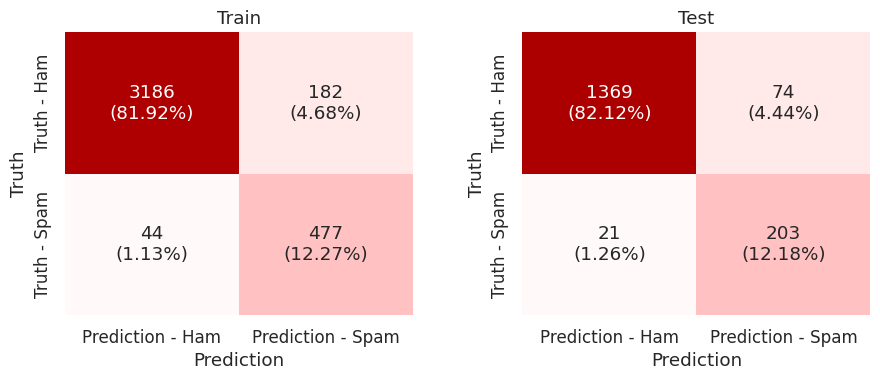

In [16]:
# Visualizing the confusion matrix of the NB model

# Reconstructing the training data
y_recon = nb_clf_model.predict(X_train_vec)
# Making prediction for the testing data
y_pred = nb_clf_model.predict(X_test_vec)

# Demonstrating the confusion matrix on the training and test set
plt.figure(figsize = (9, 4));
plt.subplot(121);
plt.title('Train');
make_confusion_matrix(y_train, y_recon);
plt.subplot(122);
make_confusion_matrix(y_test, y_pred);
plt.title('Test');
plt.tight_layout(w_pad = 3);

In [17]:
# Print a classification report
nb_eval_df = model_eval(nb_clf_model, X_train_vec, y_train, X_test_vec, y_test)
nb_eval_df

,Accuracy,Recall,Precision,F1,Specificity
Train,0.942,0.916,0.724,0.808,0.946
Test,0.943,0.906,0.733,0.810,0.949


### Building a SVM Classifier

In [18]:
sv_clf_model = SVC(class_weight = 'balanced')
sv_clf_model.fit(X_train_vec, y_train)

SVC(class_weight='balanced')

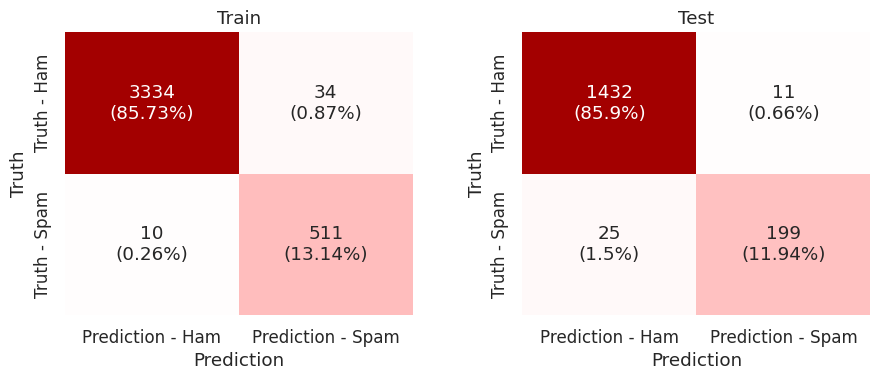

In [19]:
# Visualizing the confusion matrix of the NB model

# Reconstructing the training data
y_recon = sv_clf_model.predict(X_train_vec)
# Making prediction for the testing data
y_pred = sv_clf_model.predict(X_test_vec)

# Demonstrating the confusion matrix on the training and test set
plt.figure(figsize = (9, 4));
plt.subplot(121);
plt.title('Train');
make_confusion_matrix(y_train, y_recon);
plt.subplot(122);
make_confusion_matrix(y_test, y_pred);
plt.title('Test');
plt.tight_layout(w_pad = 3);

In [20]:
# Print a classification report
svc_eval_df = model_eval(sv_clf_model, X_train_vec, y_train, X_test_vec, y_test)
svc_eval_df

,Accuracy,Recall,Precision,F1,Specificity
Train,0.989,0.981,0.938,0.959,0.990
Test,0.978,0.888,0.948,0.917,0.992


### Tuning the SVM Classifier

In [21]:
# Defining the baseline model
base_model = SVC(class_weight = 'balanced', kernel = 'rbf')

# Defining the accuracy metric
performance_metric = make_scorer(f1_score)

# Setting the range of hyperparameters
hyperparams = {'C': [1e-4, 0.001, 0.01, 1, 2.5, 10],
               'gamma': [1e-4, 1e-3, 'auto', 'scale', 0.01, 0.1]}

# Searching over the full range of hyperparameters to find optimal values
all_models = GridSearchCV(base_model, scoring = performance_metric, 
                          param_grid = hyperparams, cv = 5)
all_models = all_models.fit(X_train_vec, y_train)

# Choosing the best-performing model
tuned_sv_clf_model = all_models.best_estimator_
print('Optimal hyperparameters:\n', all_models.best_params_, sep = '')

Optimal hyperparameters:
{'C': 2.5, 'gamma': 'auto'}


In [25]:
# Print a classification report
svc_tuned_eval_df = model_eval(tuned_sv_clf_model, X_train_vec, y_train, X_test_vec, y_test)
svc_tuned_eval_df

,Accuracy,Recall,Precision,F1,Specificity
Train,0.992,0.987,0.955,0.971,0.993
Test,0.979,0.875,0.966,0.918,0.995


#### Notes:

Since dataset is heavily imbalanced, the metric to be optimized was chosen as F1-score.

## Building a Pipeline for Both Models

Here, we put both classifiers into deployments, train them on the full data, and test them on unseen, customized reviews.

In [22]:
# One-hot-encodding the target variable
y = pd.Series(Le.transform(y))

In [23]:
# Defining the pipelines
nb_clf_pipe = Pipeline([('Text Vectorizer', TfidfVectorizer(min_df = 0.01,
                                             max_df = 0.99, stop_words = stopwords)), 
                        ('Scaler', StandardScaler(with_mean = False)),
                        ('Classifier', MultinomialNB())])
sv_clf_pipe = Pipeline([('Text Vectorizer', TfidfVectorizer(min_df = 0.01, 
                                             max_df = 0.99, stop_words = stopwords)), 
                        ('Scaler', StandardScaler(with_mean = False)),
                        ('Classifier', SVC(class_weight = 'balanced',
                                           kernel = 'rbf', gamma = 'auto', C = 2.5))])

# Training the deployed models on the full data
nb_clf_pipe.fit(X, y)
sv_clf_pipe.fit(X, y)

Pipeline(steps=[('Text Vectorizer',
                 TfidfVectorizer(max_df=0.99, min_df=0.01,
                                 stop_words=['a', 'about', 'an', 'and', 'are',
                                             'as', 'at', 'be', 'been', 'but',
                                             'by', 'can', 'even', 'ever', 'for',
                                             'from', 'get', 'had', 'has',
                                             'have', 'he', 'her', 'hers', 'his',
                                             'how', 'i', 'if', 'in', 'into',
                                             'is', ...])),
                ('Scaler', StandardScaler(with_mean=False)),
                ('Classifier',
                 SVC(C=2.5, class_weight='balanced', gamma='auto'))])

In [24]:
# Producing some custom reviews
Text1 = "Do you want a New Nokia 3510i colour phone DeliveredTomorrow? \
         With 300 free minutes to any mobile + 100 free texts + Free Camcorder reply or call 08000930705."
Text2 = "I'm on my way home. Make sure your room is clean. Let your brother know too."
Text3 = "Are we still set to talk in the evening?"
Text4 = "URGENT! Your mobile no. WON a £2000 Bonus Caller prize on 10/06/03! \
         This is the 2nd attempt to reach you! Call us ASAP!!"

# Spam analysis dataframe
sa_df = pd.DataFrame(index = ['Text 1', 'Text 2', 'Text 3', 'Text 4'], 
                     columns = ['Naive Bayes', 'SVC', 'Truth'])
sa_df.loc[:, 'Truth'] = ['Spam', 'Ham', 'Ham', 'Spam'] 

# List of texts and models to be tested
text_list = [Text1, Text2, Text3, Text4]
model_list = [nb_clf_pipe, sv_clf_pipe]

# Looping over all models and sample texts to store the prediction of models for each in a dataframe
for j, model in enumerate(model_list):
    for i, review in enumerate(text_list):
        sa_df.iloc[i, j] = Le.inverse_transform((model.predict([review])).flatten())
# Showing the prediction of all models for all sample texts
sa_df

,Naive Bayes,SVC,Truth
Text 1,[spam],[spam],Spam
Text 2,[ham],[ham],Ham
Text 3,[ham],[ham],Ham
Text 4,[spam],[spam],Spam
